In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

from itertools import combinations
from operator import itemgetter, attrgetter

from scipy.spatial.distance import cdist

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA

from sklearn.model_selection import StratifiedKFold

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import pairwise_distances, accuracy_score
from scipy.spatial.distance import cdist, pdist
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
sns.set_context('poster')
sns.set_style('white')

from tqdm import tqdm

In [2]:
dataFile = 'data.mat'

In [3]:
file = h5py.File(dataFile,'r')
experimentData = file['experimentData']
keys = list(experimentData.keys())

In [4]:
numTrials, numPositions, numGestures = experimentData[keys[0]].shape
D = file[experimentData[keys[3]][0,0,0]].shape[1]
numEx = 80

# color palettes for plotting
gPalette = sns.color_palette('tab20', numGestures)
pPalette = sns.color_palette('tab20', numPositions)

In [5]:
totalEx = numEx*numGestures*numPositions*numTrials
accFeat = np.zeros((totalEx,3))
gestLabel = np.zeros(totalEx)
posLabel = np.zeros(totalEx)
groupLabel = np.zeros(totalEx)
idx = np.arange(numEx).astype('int')
for g in range(numGestures):
    for p in range(numPositions):
        for t in range(numTrials):
            expLabel = file[experimentData['expGestLabel'][t,p,g]][0,:]
            accFeat[idx,:] = file[experimentData['accFeat'][t,p,g]][:,expLabel>0].T
            gestLabel[idx] = g
            posLabel[idx] = p
            groupLabel[idx] = g + p*numGestures
            idx += numEx
            
lda = LDA(n_components=3)
accLDA = lda.fit_transform(accFeat,posLabel)

pca = PCA(n_components=3)
accPCA = pca.fit_transform(accFeat)

In [6]:
splits = list(range(10,231,10))
acc = []
numSV = []


for numSplit in tqdm(splits):
    skf = StratifiedKFold(n_splits=numSplit)

    knnAcc = 0
    rfAcc = 0
    mlpAcc = 0
    svmAcc = 0
    xgbAcc = 0
    num = 0
    for trainIdx, testIdx in skf.split(accFeat,groupLabel):
        X_train, X_test = accFeat[trainIdx], accFeat[testIdx]
        y_train, y_test = posLabel[trainIdx], posLabel[testIdx]

    #     knn = KNeighborsClassifier()
    #     knn.fit(X_train, y_train)
    #     knnAcc += (knn.score(X_test, y_test))/numSplit

    #     rf = RandomForestClassifier()
    #     rf.fit(X_train, y_train)
    #     rfAcc += (rf.score(X_test, y_test))/numSplit

    #     mlp = MLPClassifier()
    #     mlp.fit(X_train, y_train)
    #     mlpAcc += (mlp.score(X_test, y_test))/numSplit

    #     svm = SVC(decision_function_shape='ovr',kernel='linear')
    #     svm.fit(X_train, y_train)
    #     svmAcc += (svm.score(X_test, y_test))/numSplit

        svm = SVC(decision_function_shape='ovr',kernel='linear')
        svm.fit(X_test, y_test)
        svmAcc += (svm.score(X_train, y_train))/numSplit
        num += len(svm.support_)/numSplit

    #     xgb = XGBClassifier()
    #     xgb.fit(X_train, y_train)
    #     xgbAcc += (xgb.score(X_test, y_test))/numSplit
    
    # print('K-Nearest Neighbors: %.2f%%' % (100*knnAcc))
    # print('Random Forest: %.2f%%' % (100*rfAcc))
    # print('Multi Layer Perceptron: %.2f%%' % (100*mlpAcc))
#     print('Support Vector Machine: %.2f%%' % (100*svmAcc))
    # print('XGBoost: %.2f%%' % (100*xgbAcc))
    
    acc.append(svmAcc)
    numSV.append(num)

100%|██████████| 23/23 [02:01<00:00,  5.28s/it]


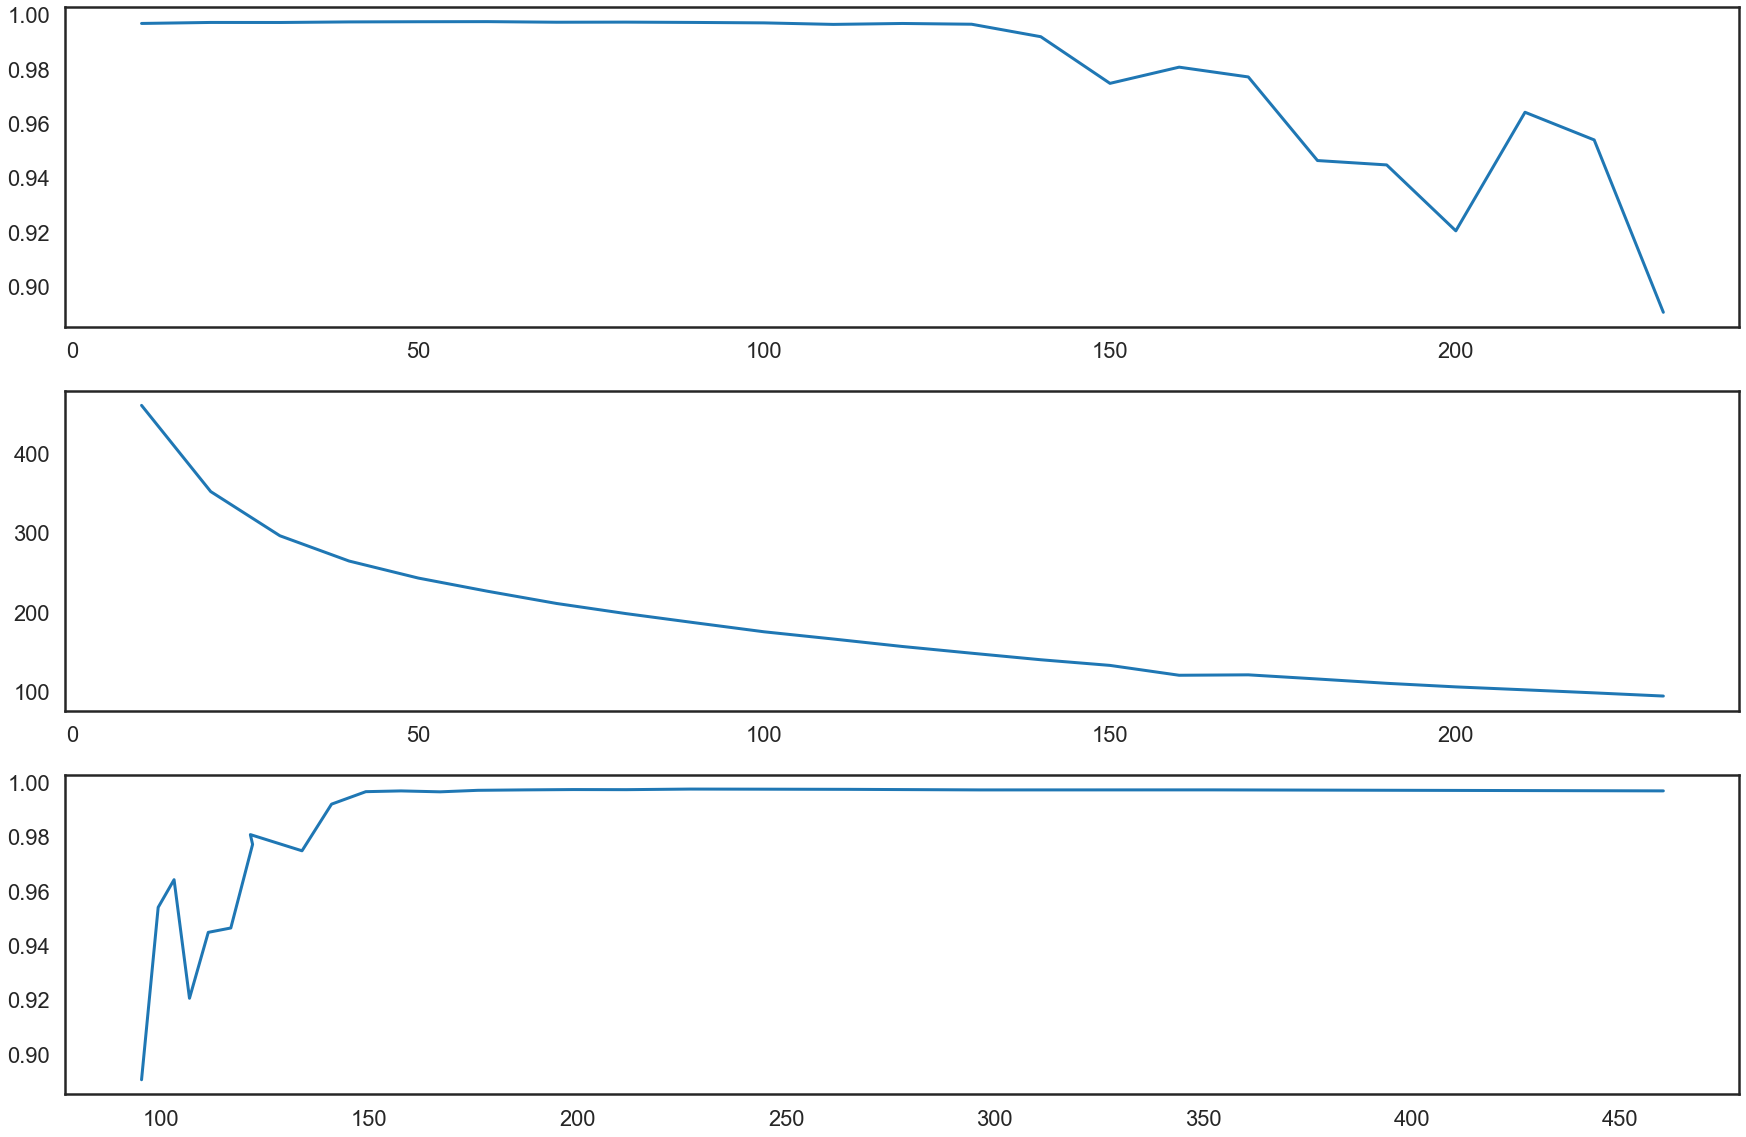

In [7]:
f,ax = plt.subplots(3,1,figsize=(30,20))
ax[0].plot(splits,acc)
ax[1].plot(splits,numSV)
ax[2].plot(numSV,acc)